# Keras Fashion MNIST TPU version

In [0]:
import os
import pprint
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dense, Dropout, Flatten

import matplotlib.pyplot as plt
%matplotlib inline
%config Inlinebackend.figure_format = 'svg'

## Ckeck our TPU

In [29]:
try:
  device_name = os.environ['COLAB_TPU_ADDR']
  print('Found TPU at: {}'.format('grpc://' + device_name))
  
  with tf.Session('grpc://' + device_name) as session:
    pprint.pprint(session.list_devices())

except KeyError:
  print('TPU not found, please check your runtime type.')

Found TPU at: grpc://10.71.200.226:8470
[_DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:CPU:0, CPU, -1, 3552585773145976979),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 8834102941843555838),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:XLA_GPU:0, XLA_GPU, 17179869184, 11508190464777568646),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 12857406213449299157),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 10208435680342378547),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 1122319454430063603),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 17856038899857356737),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:4, TPU, 17179869184, 295158527073305739),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:5, TPU, 17179869184, 105274681354425171

## Load the dataset

In [43]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

print('training data shape:', x_train.shape)
print('testing data shape:', x_test.shape)

# add empty color dimension
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

training data shape: (60000, 28, 28)
testing data shape: (10000, 28, 28)


## Build the model

In [51]:
# clear previous sessions before we build a new model
tf.keras.backend.clear_session()

model = Sequential()
model.add(BatchNormalization(input_shape=x_train.shape[1:]))
model.add(Conv2D(64, (5, 5), padding='same', activation='elu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(BatchNormalization(input_shape=x_train.shape[1:]))
model.add(Conv2D(128, (5, 5), padding='same', activation='elu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(BatchNormalization(input_shape=x_train.shape[1:]))
model.add(Conv2D(256, (5, 5), padding='same', activation='elu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('elu'))
model.add(Dropout(0.5))
model.add(Dense(10))
model.add(Activation('softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 28, 28, 1)         4         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 64)        1664      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 128)       204928    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 128)         0         
__________

## Transfer the model on TPU

In [52]:
tpu_model = tf.contrib.tpu.keras_to_tpu_model(
    model,
    strategy=tf.contrib.tpu.TPUDistributionStrategy(
        tf.contrib.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
    )
)
tpu_model.compile(
    optimizer=tf.train.AdamOptimizer(learning_rate=1e-3, ),
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=['sparse_categorical_accuracy']
)

INFO:tensorflow:Querying Tensorflow master (b'grpc://10.71.200.226:8470') for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 3552585773145976979)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 8834102941843555838)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_GPU:0, XLA_GPU, 17179869184, 11508190464777568646)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 12857406213449299157)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 10208435680342378547)
INFO:tensorflow:*** Available Device: _Devi

## Start training

In [53]:
def train_gen(batch_size):
  while True:
    offset = np.random.randint(0, x_train.shape[0] - batch_size)
    yield x_train[offset:offset+batch_size], y_train[offset:offset + batch_size]
    

history = tpu_model.fit_generator(
    train_gen(1024),
    epochs=10,
    steps_per_epoch=100,
    validation_data=(x_test, y_test),
)

Epoch 1/10
INFO:tensorflow:New input shapes; (re-)compiling: mode=train, [TensorSpec(shape=(128, 28, 28, 1), dtype=tf.float32, name='batch_normalization_input0'), TensorSpec(shape=(128, 1), dtype=tf.float32, name='activation_1_target0')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for batch_normalization_input
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 3.7219812870025635 secs
INFO:tensorflow:Setting weights on TPU model.
 99/100 [============================>.] - ETA: 0s - loss: 1.0247 - sparse_categorical_accuracy: 0.7289INFO:tensorflow:New input shapes; (re-)compiling: mode=eval, [TensorSpec(shape=(128, 28, 28, 1), dtype=tf.float32, name='batch_normalization_input0'), TensorSpec(shape=(128, 1), dtype=tf.float32, name='activation_1_target0')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for batch_normalization_input
INFO:tensorflow:Started compiling
INFO:tensorfl

## Checkout our training result

In [0]:
def plot_hist(train_loss, train_acc, test_loss, test_acc):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
  
  ax1.plot(train_loss, label='train loss')
  ax1.plot(test_loss, label='test loss')
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  ax1.set_title('Train & Test Loss')
  ax1.legend()
  
  
  ax2.plot(train_acc, label='train acc')
  ax2.plot(test_acc, label='test acc')
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Accuracy')
  ax2.set_title('Train & Test Accuracy')
  ax2.legend()
    
  plt.show()

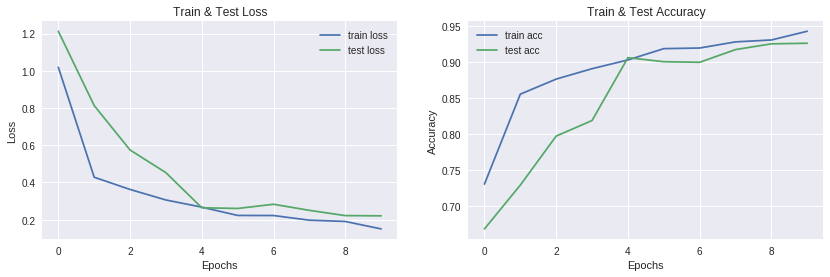

In [63]:
plot_hist(history.history['loss'], 
     history.history['sparse_categorical_accuracy'],
     history.history['val_loss'],
     history.history['val_sparse_categorical_accuracy']
    )

INFO:tensorflow:Copying TPU weights to the CPU


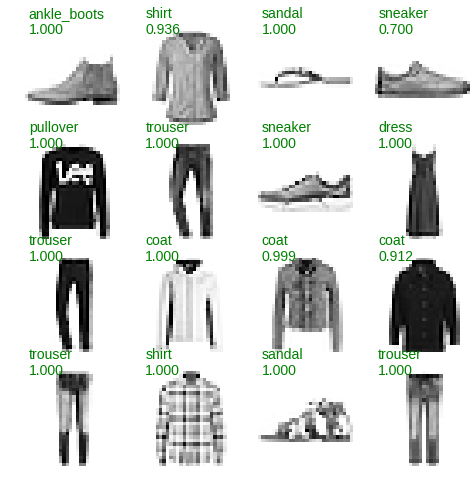

In [64]:
# 10 different categories
LABEL_NAMES = ['t_shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle_boots']

# sync our model to cpu before inference
cpu_model = tpu_model.sync_to_cpu()


def plot_predictions(images, predictions, correct_label):
  n = images.shape[0]
  nc = int(np.ceil(n / 4))
  f, axes = plt.subplots(nc, 4)
  for i in range(nc * 4):
    y = i // 4
    x = i % 4
    axes[x, y].axis('off')
    
    label = np.argmax(predictions[i])
    label_name = LABEL_NAMES[label]
    confidence = predictions[i][label]
    if i > n:
      continue
    axes[x, y].imshow(images[i])
    txt_color = 'g' if label == correct_label[i] else 'r'
    axes[x, y].text(0.5, 0.5, label_name + '\n%.3f' % confidence, fontsize=14, color=txt_color)

  plt.gcf().set_size_inches(8, 8)  

# plot our predictions
plot_predictions(np.squeeze(x_test[:16]), 
                 cpu_model.predict(x_test[:16]),
                 y_test[:16])